# How to Connect to Coinbase REST API and Display Bitcoin Historic Data?

by Nils Ackermann

## Introduction

In case you want to get started as a crypto investor and you want to take matters into your own hands, it is important that you are able to connect to a currency exchange such as [pro.coinbase.com](https://pro.coinbase.com). This is the essential first step to start data analysis and automation and move into algorithmic trading. In this notebook you will learn the following:

- How to connect to the public coinbase.com pro REST API via Python
- How to load data from coinbase into Pandas
- How to visualize Bitcoin (or any other crypto currency) historic data in Python

The example uses Coinbase Pro as an exchange but it should be easily transferable to the other major digital currency exchange [Kraken](https://www.kraken.com). The full pro.coinbase.com documentation can be found [here](https://docs.pro.coinbase.com).

## Step 0 - Imports, Libraries and Functions

For the example, we need the following python imports:

- **Requests:** For connecting to the REST endpoints from Coinbase Pro, we will use [this](http://docs.python-requests.org/en/master/) great HTTP library. Very user friendly. Only a few lines of code to connect via REST. 
- **Pandas:** For data analysis and manipulation we use [Pandas](https://pandas.pydata.org).
- **Json:** We are dealing with json format, therefore let's import it. The documentation is [here](https://docs.python.org/3/library/json.html)
- **Datetime:** We are doing some smaller data calculations, therefore we need [Datetime](https://docs.python.org/3/library/datetime.html).
- **Matplotlib:** At the end of the notebook, we will visualize some data, therefore we need [this](https://matplotlib.org) library.
- **MPL Finance:** Formerly part of matplot lib, the finance module has been deprecated and is now in its own library. You can find more information [here](https://github.com/matplotlib/mplfinance). We use this library to do the financial plotting at the end of the notebook. There is also an older version called mpl-finance. In case you have worked with mpl-finance before, I have also included the code in the backup at the end of the notebook.
- **Seaborn:** For a nicer visualization of the plots, we will use [Seaborn](https://seaborn.pydata.org).

Since we will reuse some of the code throughout the notebook, we will define one functions first:

- connect(url,param): this function takes the URL and optionally the parameters to a REST endpoint as an input
. It then returns the response. If an error occurs, an exception is thrown and the error is printed.

In [2]:
import requests
from requests.exceptions import HTTPError
import pandas as pd
import json as js
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
# Uncomment this if you like to use the old MPL library
#from mpl_finance import candlestick_ohlc
import mplfinance as mpf
import matplotlib.dates as mpl_dates
import matplotlib.ticker as tkr
%matplotlib inline
import seaborn as sns

In [3]:
# Set some standard parameters upfront
pd.options.display.float_format = '{:.1f}'.format
sns.set() # default seaborn look and feel
plt.style.use('ggplot')
REST_API = 'https://api.pro.coinbase.com'
PRODUCTS = REST_API+'/products'
# I am only interested in a few currencies that I want to trade, so let's add them here:
MY_CURRENCIES = ['BTC-EUR','ETH-EUR','LTC-EUR','BCH-EUR'] 


In [4]:
def connect(url, *args, **kwargs):
    try:
        if kwargs.get('param', None) is not None:
            response = requests.get(url,params)
        else:
            response = requests.get(url)
        response.raise_for_status()
        #print('HTTP connection success!')
        return response
    except HTTPError as http_err:
        print(f'HTTP error occurred: {http_err}')
    except Exception as err:
        print(f'Other error occurred: {err}')

## Step 1 - Connect to REST Endpoint

Connect to the Coinbase REST endpoint (/products) to retrieve all products that are currently available for trading on Coinbase Pro. We are using a try / except block in the function defined above to react to potential connectivity issues.

In [5]:
response = connect(PRODUCTS)
response_content = response.content
response_text = response.text
response_headers = response.headers

## Step 2 - Get Basic Currency Information

Let's print some basic information about the currencies that I have downselected above: Bitcoin, Ethereum, Litecoin and Bitcoin Cash.

In [6]:
df_currencies = pd.read_json (response_text)
print("\nNumber of columns in the dataframe: %i" % (df_currencies.shape[1]))
print("Number of rows in the dataframe: %i\n" % (df_currencies.shape[0]))
columns = list(df_currencies.columns)
print(columns)
print() 
df_currencies[df_currencies.id.isin(MY_CURRENCIES)][['id', 'quote_currency', 'base_min_size', 'base_max_size']].head(5)


Number of columns in the dataframe: 19
Number of rows in the dataframe: 287

['id', 'base_currency', 'quote_currency', 'base_min_size', 'base_max_size', 'quote_increment', 'base_increment', 'display_name', 'min_market_funds', 'max_market_funds', 'margin_enabled', 'fx_stablecoin', 'max_slippage_percentage', 'post_only', 'limit_only', 'cancel_only', 'trading_disabled', 'status', 'status_message']



,id,quote_currency,base_min_size,base_max_size
88,ETH-EUR,EUR,0.0,1600.0
104,BTC-EUR,EUR,0.0,200.0
141,BCH-EUR,EUR,0.0,400.0
191,LTC-EUR,EUR,0.0,1000.0


## Step 3 - Get More Statistics

Ok - great. We see that we are able to connect to the Coinbase Pro API with only a few lines of code. Next, we are interested in what has happened over the last 24 hours for each of our favorite currency:
- Open: the opening value in EUR
- High: the highest price in EUR
- Low: the lowest price in EUR
- Last: the current price in EUR
- Volume: volume of trades

In [7]:
currency_rows = []
for currency in MY_CURRENCIES:
    response = connect(PRODUCTS+'/'+currency+'/stats')
    response_content = response.content
    data = js.loads(response_content.decode('utf-8'))
    currency_rows.append(data)
# Create dataframe and set row index as currency name
df_statistics = pd.DataFrame(currency_rows, index = MY_CURRENCIES)
df_statistics

,open,high,low,volume,last,volume_30day
BTC-EUR,42085.34,42493.41,41648.16,679.79057118,42381.38,40442.1791433
ETH-EUR,3248.5,3332.84,3227.41,11541.35426521,3300.33,613910.07531908
LTC-EUR,177.38,193.2,177.12,103770.03251719,189.19,1121400.04886127
BCH-EUR,595.33,618.67,588.31,9534.84507261,615.55,119472.00185749


## Step 4: Drill Down Into Bitcoin Historic Data

We now want to find out how the price has developed over the last 90 days. We will use Bitcoin as an example. For now, a simple table view of the data is good enough for us. 

In [8]:
start_date = (datetime.today() - timedelta(days=90)).isoformat()
end_date = datetime.now().isoformat()
# Please refer to the coinbase documentation on the expected parameters
params = {'start':start_date, 'end':end_date, 'granularity':'86400'}
response = connect(PRODUCTS+'/ADA-USD/candles', param = params)
response_text = response.text
df_history = pd.read_json(response_text)
# Add column names in line with the Coinbase Pro documentation
df_history.columns = ['time','low','high','open','close','volume']


In [9]:
# We will add a few more columns just for better readability
df_history['date'] = pd.to_datetime(df_history['time'], unit='s')
df_history['year'] = pd.DatetimeIndex(df_history['date']).year
df_history['month'] = pd.DatetimeIndex(df_history['date']).month
df_history['day'] = pd.DatetimeIndex(df_history['date']).day
# Only display the first 5 rows
df_history.head(5).drop(['time','date'], axis=1)

,low,high,open,close,volume,year,month,day
0,2.8,2.9,2.8,2.9,51300722.4,2021,9,5
1,2.8,3.0,3.0,2.8,94616818.9,2021,9,4
2,2.9,3.0,3.0,3.0,108852651.3,2021,9,3
3,2.8,3.1,2.9,3.0,174814779.0,2021,9,2
4,2.7,2.9,2.8,2.9,93378811.0,2021,9,1


## Step 5 - Candlestick Chart

As the final step, let's view the data as a candlestick chart. As a bonus, the chart is also enhanced with the moving average and the total volume traded within each time slice. And all of this with only a few lines of code. How great is that!

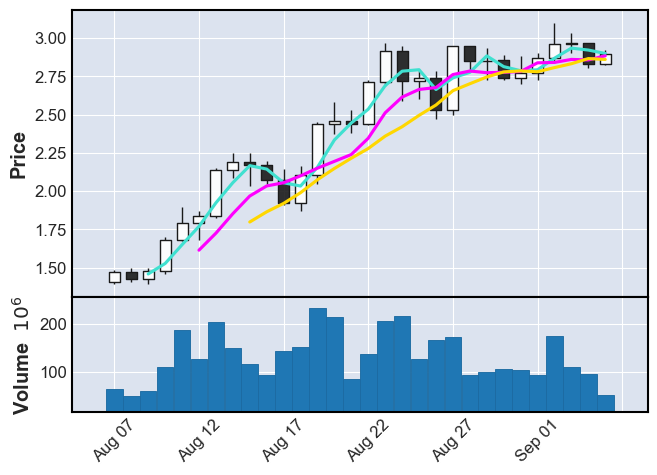

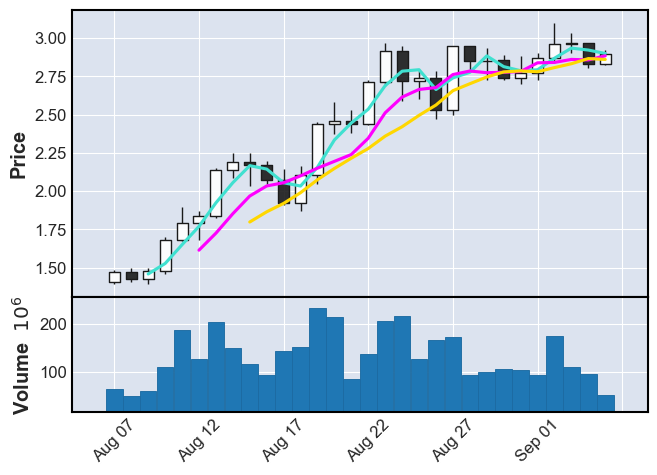

In [10]:
# Make a copy of the original dataframe
df_ohlc = df_history
# Remove unnecessary columns and only show the last 30 days
df_ohlc = df_ohlc.drop(['time','year','month','day'], axis = 1).head(30)
# Columns must be in a specific order for the candlestick chart (OHLC)
df_ohlc = df_ohlc[['date', 'open', 'high', 'low', 'close','volume']]
# Index must be set as the date
df_ohlc.set_index('date', inplace=True)
# Inverse order is expected so let's reverse the rows in the dataframe
df_ohlc = df_ohlc[::-1]
mpf.plot(df_ohlc,type='candle',mav=(3,6,9),volume=True)


## Wrap Up

You made it to the end of the notebook. Thanks a lot for taking the time to go through the code. Maybe the fire is ignited and you will start coding your own solution on top of the great digital currency APIs out there. 

Go build!